# Strojno učenje - PMF

Akademska godina 2017./2018.
[https://web.math.pmf.unizg.hr/nastava/su/](https://web.math.pmf.unizg.hr/nastava/su/)

Matija Piškorec

kernel: Python 3.6

# 4. Smanjivanje dimenzionalnosti

Glavni cilj smanjivanja dimenzionalnosti je projicirati naše podatke u prostor niže dimenzionalnosti ali tako da se održi što više korisne informacije (prema nekom kriteriju) o originalnim podacima. Projiciranje podataka u drugi prostor se ponekad naziva i ekstrakcijom ili generiranjem značajki (engl. feature extraction) zato što efektivno stvaramo nove atribute.

Primjerice, analiza glavnih komponenti (engl. principal component analysis, PCA) je linearna projekcija podataka gdje su nove značajke (komponente) poredane po količini varijance koju objašnjavaju u originalnim podacima. U tom slučaju možemo smanjiti dimenzionalnost podataka tako da samo zadržimo prvih nekoliko komponenti i odbacimo ostale. Tehnički, ovo je jako slično odabiru značajki, s time da ovdje odabiremo značajke u transformiranom prostoru.

Većina sadržaja ove vježbe preuzeta je s jedne od vježbi za [First Int'l Summer School on Data Science](https://sites.google.com/site/ssdatascience2016/lecture-notes) održanoj u Splitu u rujnu 2016., koje su dostupne na [Github repozitoriju](https://github.com/SSDS2016/Day-3). Od ostalih materijala, službena scikit-learn [korisnička dokumentacija](http://scikit-learn.org/stable/user_guide.html) ima nekoliko primjera s PCA i drugim metodama smanjivanja dimenzionalnosti [[1]](#scikit-decomposition), a postoje i korisni primjeri na Githubu [[2]](#islr-ch10),[[3]](pyml-ch5),[[4]](#sklearn_pycon2015).

Preduvjeti
--------------

U ovoj vježbi koristit ćemo "Wisconsin Breast Cancer" dataset koji sadrži 569 primjera i 30 atributa, dok je ciljna varijabla ili 1 (maligni tumor) ili 0 (benigni tumor). Dataset je dostupan lokalno, inače se može dohvatiti preko scikit-learn funkcije [`sklearn.datasets.load_breast_cancer`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) (verzija 0.17.1).

Za ostale datasetove dostupne unutar scikit-learna pogledajte službenu dokumentaciju na [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [3]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

Iako nije nužno potrebno u našem slučaju, slijedit ćemo standardnu praksu strojnog učenja i podijeliti naš dataset u skup za treniranje i skup za testiranje s funkcijom [`sklearn.cross_validation.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html), te provesti svu analizu samo na skupu za treniranje.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)
print('Broj primjera za treniranje: ' + str(len(breast_cancer_train)))
print('Broj primjera za testiranje: ' + str(len(breast_cancer_test)))

Broj primjera za treniranje: 455
Broj primjera za testiranje: 114


4.1. Eksploratorna analiza breast cancer dataseta
----------------------------------------------------------

Prije nego transformiramo naš dataset u novi prostor značajki, analizirajmo ga prvo uz pomoć pojedinačnih histograma za svaku od značajki i za svaki ishod ciljne varijable. Za sličan primjer pogledajte poglavlje 3 iz knjige "Introduction to Machine Learning with Python" [[5]](#intro-ml-py).

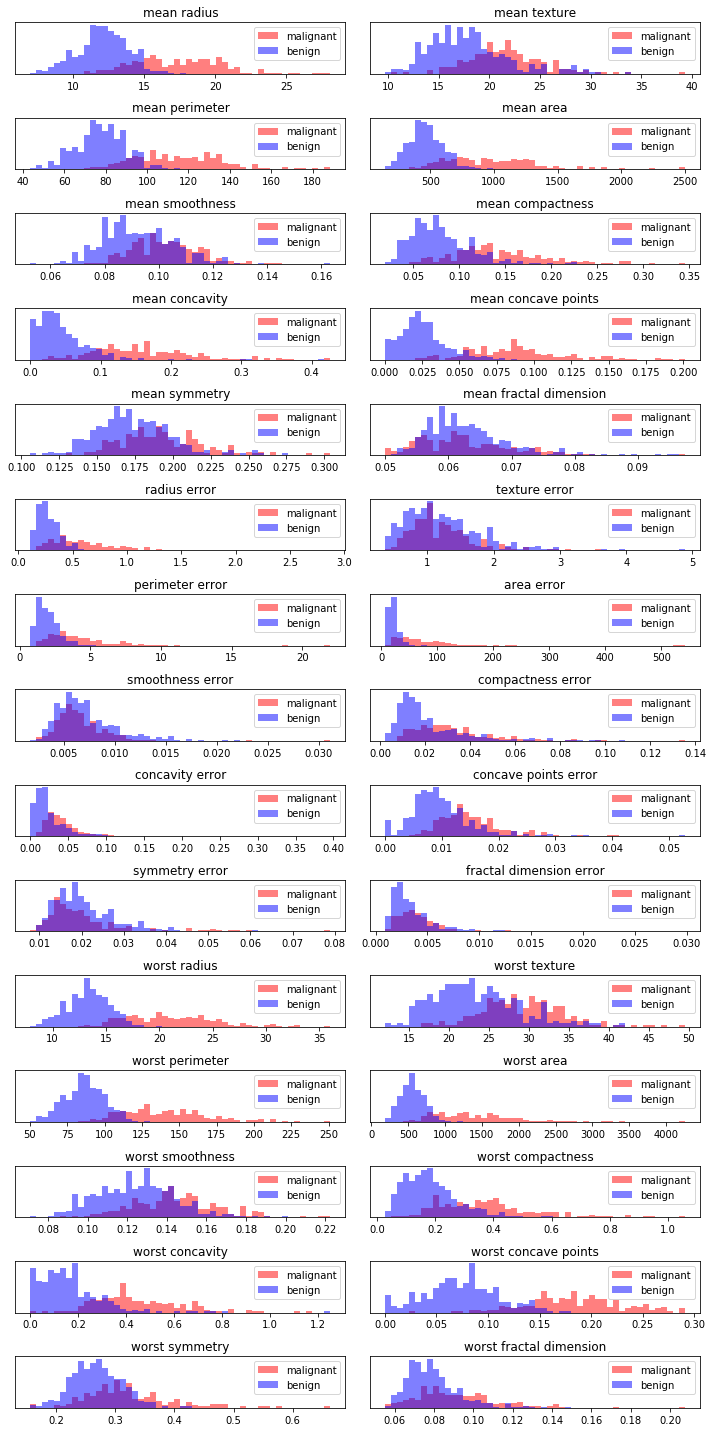

In [6]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)

malignant = breast_cancer.loc[ breast_cancer['target'] == 0, : ]
benign = breast_cancer.loc[ breast_cancer['target'] == 1, : ]

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
ax = axes.ravel() # axes are 2-dimensional so we unfold them
for i in range(30):
    _, bins = np.histogram(breast_cancer.iloc[:,i], bins=50)
    ax[i].hist(malignant.iloc[:,i], bins=bins, color='r', alpha=.5, label='malignant')
    ax[i].hist(benign.iloc[:,i], bins=bins, color='b', alpha=.5, label='benign')
    ax[i].set_title(breast_cancer.columns.values[i])
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right')
fig.tight_layout()

Idealno, želimo da se naše dvije klase (maligna i benigna) u potpunosti razdvoje uz pomoć barem jedne značajke. U tom slučaju naš prediktivni model bi bio jako jednostavan, pošto bi samo morali provjeriti je li vrijednost te značajke iznad ili ispod određene granične vrijednosti. Nažalost, ovdje to nije slučaj.

**Vježba 4.1.** Gledajući histograme izračunate ranije, koje značajke se čine korelirane? Potvrdite to računanjem potpune matrice korelacije uz pomoć [`pandas.DataFrame.corr`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) nakon čega je prikažite s [`matplotlib.pyplot.imshow`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow).

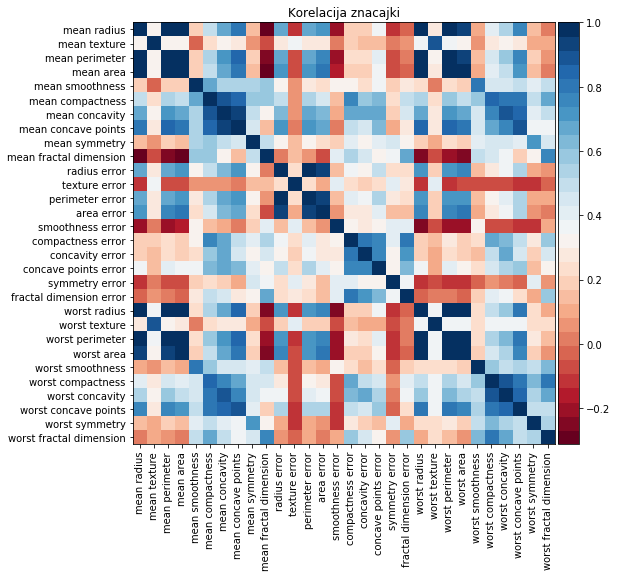

In [7]:
from matplotlib import cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

X_corr = breast_cancer.drop('target',axis=1).corr()
cmap = cm.get_cmap('RdBu', 30)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
iax = ax.imshow(X_corr, interpolation="nearest", cmap=cmap)
ax.grid(False)
ax.set(title='Korelacija znacajki')
ax.set_xticks(range(X_corr.shape[1]))
ax.set_xticklabels(breast_cancer.drop('target',axis=1).columns.values, rotation=90)
ax.set_yticks(range(X_corr.shape[1]))
ax.set_yticklabels(breast_cancer.drop('target',axis=1).columns.values)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(iax,cax)

plt.show()

4.2. Analiza glavnih komponenti (PCA)
-----------------------------

Iz eksploratorne analize vidimo da su brojne značajke korelirane. Iskoristit ćemo analizu glavnih komponenti (engl. principal component analysis, PCA) da projiciramo naše podatke u novi prostor značajki (komponenti) gdje su one ortogonalne i poredane po količini varijance koju objašnjavaju u originalnim podacima. Za računanje PCA komponenti koristit ćemo [`sklearn.decomposition.PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), no prije toga ćemo standardizirati sve značajke s funkcijom [`sklearn.preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) koja oduzima srednju vrijednost i standardizira sve značajke tako da imaju jediničnu varijancu.

Za više detalja pogledajte službenu dokumentaciju ["2.5.1. Principal component analysis (PCA)"](http://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca).

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [17]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)

scaler = StandardScaler()
X = breast_cancer.drop('target',axis=1)
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA() # use option n_components=2 to calculate just first two principal components
pca.fit(X_scaled) # fit PCA model to breast cancer data
X_pca = pca.transform(X_scaled) # transform data onto the principal components
print("Dimenzije originalnih podataka: %s" % str(X_scaled.shape))
print("Dimenzije projiciranih podataka: %s" % str(X_pca.shape))

Dimenzije originalnih podataka: (569, 30)
Dimenzije projiciranih podataka: (569, 30)


Vidimo da projicirani podaci i dalje imaju dimenzije originalnih podataka. Ali transformirane značajke, ili *glavne komponente* (engl. principal components) su sada poredane po količini varijance koju objašnjavaju u originalnim podacima.

In [18]:
breast_cancer_pca = pd.DataFrame(X_pca, columns=['PC'+str(i) for i in range(1,X_pca.shape[1]+1)])
breast_cancer_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214


**Vježba 4.2.** Izračunajte i prikažite poptunu matricu korelacije za glavne komponente u projiciranom datasetu. Postoji li neka razlika u usporedbi s korelacijskom matricom originalnog dataseta?

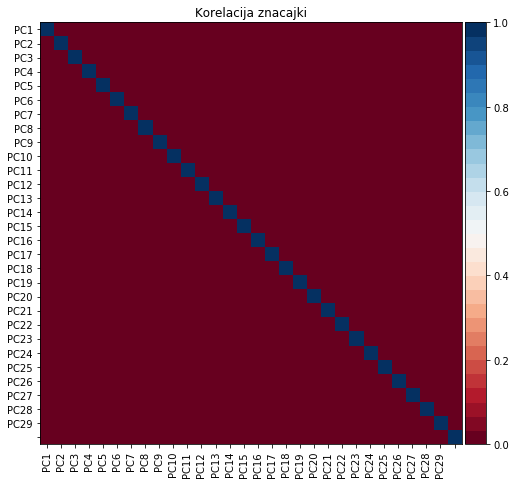

In [19]:
from matplotlib import cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

X_corr = breast_cancer_pca.corr()
cmap = cm.get_cmap('RdBu', 30)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
iax = ax.imshow(X_corr, interpolation="nearest", cmap=cmap)
plt.grid(False)
ax.set(title='Korelacija znacajki')
ax.set_xticks(range(X_corr.shape[1]))
ax.set_xticklabels(breast_cancer_pca.columns.values[:-1], rotation=90)
ax.set_yticks(range(X_corr.shape[1]))
ax.set_yticklabels(breast_cancer_pca.columns.values[:-1])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(iax,cax)

plt.show();

Možemo prikazati varijancu objašnjenu sa svakom od glavnih komponenti, kao i kumulativnu varijancu objašnjenu uključivanjem svake naredne glavne komponente u našem projiciranom datasetu.

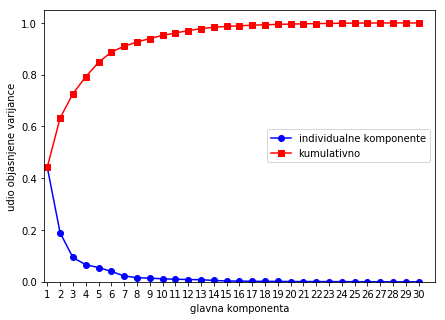

In [20]:
plt.figure(figsize=(7,5))

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cummulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio, '-o', label='individualne komponente', c='b')
plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio_cummulative, '-s', label='kumulativno', c='r')

plt.ylabel('udio objasnjene varijance')
plt.xlabel('glavna komponenta')
plt.xlim(0.75,X_pca.shape[1]+1.25)
plt.ylim(0,1.05)
plt.xticks(range(1,X_pca.shape[1]+1))
plt.legend(loc='center right')
plt.show()

Primjećujemo da prve dvije komponente zajedno objašnjavaju više od 60% varijance u podacima, a prvih deset više od 95%. S obzirom da nam originalni podaci imaju 30 značajki ovo je značajna redukcija. Pogledajmo kako naši podaci izgledaju kada se projiciraju na prve dvije glavne komponente.

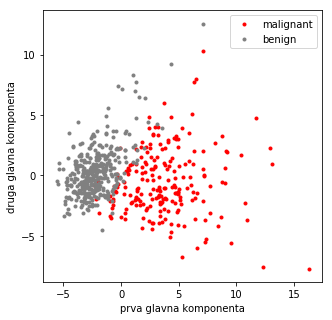

In [21]:
plt.figure(figsize=(5, 5))

plt.scatter(breast_cancer_pca.loc[breast_cancer.loc[:,'target']==0,'PC1'], 
            breast_cancer_pca.loc[breast_cancer.loc[:,'target']==0,'PC2'], 
            color='red', marker='.', label='malignant')
plt.scatter(breast_cancer_pca.loc[breast_cancer.loc[:,'target']==1,'PC1'], 
            breast_cancer_pca.loc[breast_cancer.loc[:,'target']==1,'PC2'], 
            color='gray', marker='.', label='benign')

plt.legend()
plt.xlabel("prva glavna komponenta")
plt.ylabel("druga glavna komponenta")
plt.show()

**Vježba 4.3.** Konstruirajte dva dataseta - jedan koji sadrži samo dva jako korelirana atributa i jedan koji koristi samo dva manje korelirana atributa (iskoristite korelacijsku matricu izračunatu ranije kao pomoć). Izračunajte PCA za oba dataseta i usporedite varijance objašnjene svakom od komponenti. Koji od navedena dva dataseta ima više varijance objašnjene s prvom glavnom komponentom i zašto?

In [22]:
breast_cancer_correlated = breast_cancer[['mean radius','mean perimeter']]
breast_cancer_uncorrelated = breast_cancer[['mean radius','worst concavity']]

R1 = breast_cancer_correlated.corr().loc['mean radius','mean perimeter']
R2 = breast_cancer_uncorrelated.corr().loc['mean radius','worst concavity']

print('Korelacija izmedju "mean radius" i "mean perimeter" = ' + '{0:.3f}'.format(R1))
print('Korelacija izmedju "mean radius" i "worst concavity" = ' + '{0:.3f}'.format(R2))

Korelacija izmedju "mean radius" i "mean perimeter" = 0.998
Korelacija izmedju "mean radius" i "worst concavity" = 0.527


In [23]:
X_scaled_correlated = StandardScaler().fit(breast_cancer_correlated).transform(breast_cancer_correlated)
variance_correlated = PCA().fit(X_scaled_correlated).explained_variance_ratio_

X_scaled_uncorrelated = StandardScaler().fit(breast_cancer_uncorrelated).transform(breast_cancer_uncorrelated)
variance_uncorrelated = PCA().fit(X_scaled_uncorrelated).explained_variance_ratio_

print('Objasnjena varijanca (korelirani atributi), PC1 = ' + str(variance_correlated[0]) + ', PC2 = ' + str(variance_correlated[1]))
print('Objasnjena varijanca (nekorelirani atributi), PC1 = ' + str(variance_uncorrelated[0]) + ', PC2 = ' + str(variance_uncorrelated[1]))

Objasnjena varijanca (korelirani atributi), PC1 = 0.9989276407469055, PC2 = 0.0010723592530945717
Objasnjena varijanca (nekorelirani atributi), PC1 = 0.7634557309192727, PC2 = 0.23654426908072745


Kod koreliranih atributa veći udio varijance je objašnjen s prvom glavnom komponentnom.

4.3. Prediktivno modeliranje nakon PCA projekcije
----------------------------------------------

Iako PCA analiza može biti korisna i u drugim primjenama (na primjer, u grupiranju podataka) ovdje nas najviše zanima može li nam pomoći u predikciji. Pošto PCA efektivno dekorelira značajke, trebala bi pomoći kod metoda gdje je prisutnost velikog broja koreliranih značajki problematično. Također, predikcija na smanjenom datasetu je računalno efikasnija. U sljedećem primjeru ćemo kao tehniku klasifikacije koristiti logističku regresiju implementiranu u [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Točnost naših predikcija ćemo evaluirati s unakrsnom validacijom (engl. cross-validation) implementiranom u [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) za različiti broj glavnih komponenti. Na kraju ćemo najbolji model evaluirati na zasebnom test skupu.

Za pojednostavljenje predikcijskog workflowa koristit ćemo [`sklearn.pipeline.Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Osim što poboljšavaju čitljivost programskog koda, pipelineovi osiguravaju izvršavanje svih koraka za pretprocesiranje i na testnom skupu. Za sličan primjer pogledajte ["Pipelining: chaining a PCA and a logistic regression"](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html), 

Napomena: Pošto je broj malignih i benignih primjera u našem skupu podataka otprilike podjednak (provjerite s  `breast_cancer['target'].value_counts()`) možemo korisiti točnost ([`sklearn.metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)) kao evaluacijsku mjeru za naš klasifikator.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [25]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.30, random_state=39)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

X_test = breast_cancer_test.drop('target',axis=1)
y_test = breast_cancer_test['target']

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('pca', PCA()),
                       ('logistic',LogisticRegression())])

components_to_evaluate = 10

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=range(1,components_to_evaluate)),
                         cv=10,
                         scoring='accuracy')

model = estimator.fit(X_train, y_train)

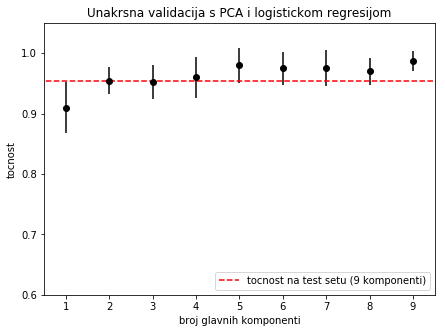

In [26]:
plt.figure(figsize=(7,5))

results_selected = zip(model.cv_results_['params'],model.cv_results_['mean_test_score'],model.cv_results_['std_test_score'])
for params, mean_scores, std_scores in results_selected:
    plt.errorbar(params['pca__n_components'], mean_scores, yerr=std_scores, fmt='ok')

plt.hlines(accuracy_score(y_test, model.predict(X_test)), 0, components_to_evaluate, 
           color='red', linestyle='--', 
           label='tocnost na test setu (' + str(model.best_params_['pca__n_components']) + ' komponenti)')

plt.ylabel('tocnost')
plt.xlabel('broj glavnih komponenti')
plt.title('Unakrsna validacija s PCA i logistickom regresijom')
plt.xlim(0.5,components_to_evaluate-0.5)
plt.ylim(0.6,1.05)
plt.xticks(range(1,components_to_evaluate))
plt.legend(loc='lower right')
plt.show()

Literatura
-----------

<a name="scikit-decomposition">[1]</a> *"scikit-learn documentation - 2.5. Decomposing signals in components"*, [link](http://scikit-learn.org/stable/modules/decomposition.html)

<a name="islr-ch10">[2]</a> *"ISLR-Python - Chapter 10"*, [link](https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%2010.ipynb)

<a name="pyml-ch5">[3]</a> *"Python Machine Learning Code examples - Chapter 5"*, [link](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch05/ch05.ipynb)

<a name="sklearn_pycon2015">[4]</a> *"PyCon 2015 Scikit-learn Tutorial - 04.1-Dimensionality-PCA"*, [link](https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/04.1-Dimensionality-PCA.ipynb)

<a name="intro-ml-py">[5]</a> *"Introduction to Machine Learning with Python - Chapter 3 Unsupervised Learning and Preprocessing"* 

<a name="pymf">[6]</a> *"PyMF - Python Matrix Factorization Module"*, [link](https://github.com/cthurau/pymf)

<a name="pyml-ch4">[7]</a> *"Python Machine Learning Code examples - Chapter 4"*, [link](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb)